# Prepare data

In [2]:
USE_SUBSET = True

In [3]:
import pandas as pd
from fastai.vision.all import *


In [5]:
df_articles = pd.read_parquet("../Data/processed_articles.parquet")

# Get relevant product groups

In [6]:
counts = df_articles["product_group_name"].value_counts()
counts


Garment Upper body       42680
Garment Lower body       19770
Garment Full body        13276
Accessories              11005
Underwear                 5462
Shoes                     5156
Swimwear                  3125
Socks & Tights            2431
Nightwear                 1898
Unknown                    121
Underwear/nightwear         54
Cosmetic                    48
Bags                        25
Items                       17
Furniture                   13
Garment and Shoe care        9
Stationery                   5
Interior textile             3
Fun                          2
Name: product_group_name, dtype: int64

In [7]:
relevant_product_groups = counts[counts >= 19_770].index.to_list()
print(relevant_product_groups)


['Garment Upper body', 'Garment Lower body']


In [8]:
df_articles = df_articles[
    df_articles["product_group_name"].isin(relevant_product_groups)
]


# Prepare a final pandas dataframe

In [9]:
df = df_articles[["article_id", "product_code", "product_group_name", "path"]]
df.head()


,article_id,product_code,product_group_name,path
0,0108775015,108775,Garment Upper body,../Rawdata/images/010/0108775015.jpg
1,0108775044,108775,Garment Upper body,../Rawdata/images/010/0108775044.jpg
2,0108775051,108775,Garment Upper body,../Rawdata/images/010/0108775051.jpg
8,0111586001,111586,Garment Lower body,../Rawdata/images/011/0111586001.jpg
11,0112679048,112679,Garment Upper body,../Rawdata/images/011/0112679048.jpg


# Classification

In [10]:
if USE_SUBSET:
    df = df.groupby("product_group_name", group_keys=False).apply(lambda x: x.sample(150))
    print(df.shape)

(300, 4)


In [11]:
# refactor get_x and get_y to functions if we want to serialize the learner later
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_x=lambda r: r["path"],
    get_y=lambda r: r["product_group_name"],
    item_tfms=RandomResizedCrop(128),
    batch_tfms=aug_transforms(),
)


In [12]:
dls = dblock.dataloaders(df, bs=64)


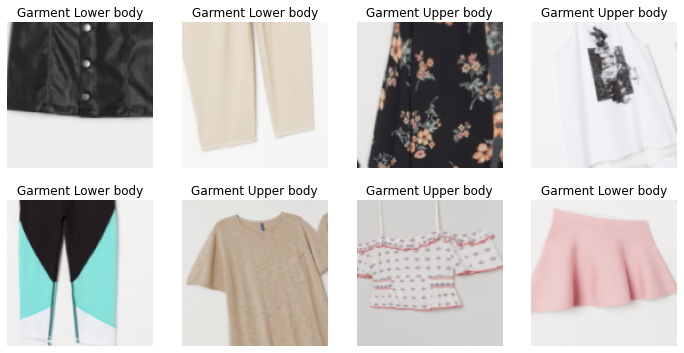

In [14]:
dls.train.show_batch(ncols=4, nrows=2)


In [14]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)


epoch,train_loss,valid_loss,error_rate,time


KeyboardInterrupt: 

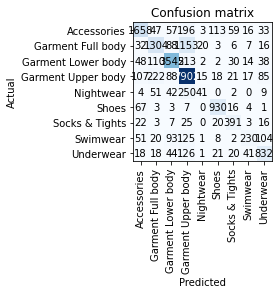

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


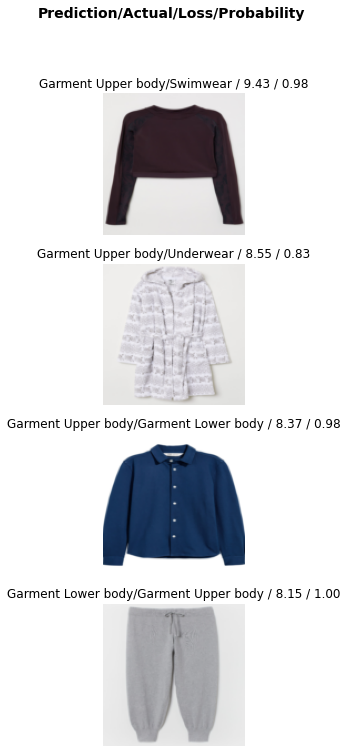

In [20]:
interp.plot_top_losses(4, nrows=4)
